In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
BASE_DIR = 'E:/capstone'  # Your dataset directory
WORKING_DIR = ''

In [4]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
# extract features from image
'''
features = {}
directory = os.path.join(BASE_DIR, 'flickr8k/Images')


for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature
'''

"\nfeatures = {}\ndirectory = os.path.join(BASE_DIR, 'flickr8k/Images')\n\n\nfor img_name in tqdm(os.listdir(directory)):\n    # load the image from file\n    img_path = directory + '/' + img_name\n    image = load_img(img_path, target_size=(224, 224))\n    # convert image pixels to numpy array\n    image = img_to_array(image)\n    # reshape data for model\n    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))\n    # preprocess image for vgg\n    image = preprocess_input(image)\n    # extract features\n    feature = model.predict(image, verbose=0)\n    # get image ID\n    image_id = img_name.split('.')[0]\n    # store feature\n    features[image_id] = feature\n"

In [6]:
# store features in pickle
#pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [7]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [8]:
with open(os.path.join(BASE_DIR, 'flickr8k/captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
# create mapping of image to captions

mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)


  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
len(mapping)

8091

# > **Preprocess text data**

In [11]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
           
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [12]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
# preprocess the text
clean(mapping)

In [14]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
len(all_captions)

40455

In [17]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [18]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [19]:
vocab_size

8485

In [20]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [21]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [22]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [23]:
#!pip install pydot

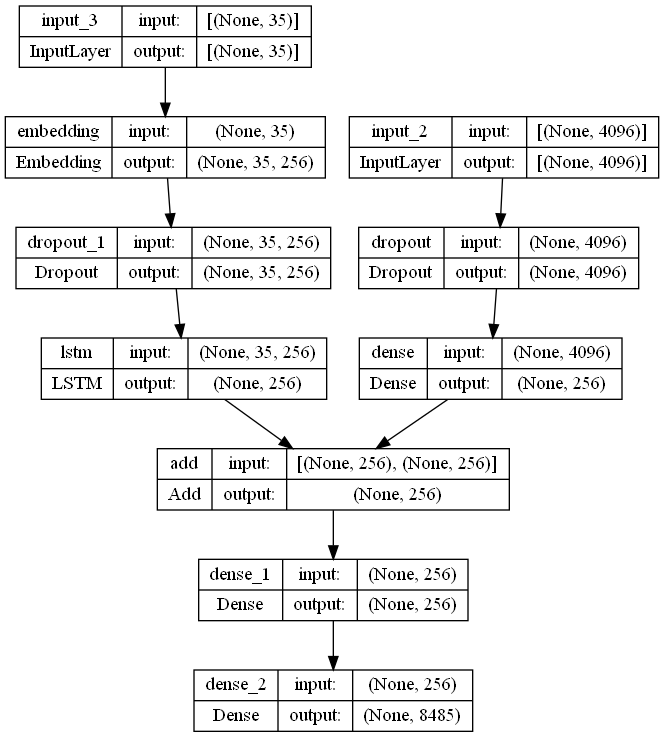

In [24]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [25]:
# train the model
'''
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
'''

'\nepochs = 20\nbatch_size = 32\nsteps = len(train) // batch_size\n\nfor i in range(epochs):\n    # create data generator\n    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)\n    # fit for one epoch\n    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)\n'

In [26]:
# save the model
#model.save(WORKING_DIR+'/best_model.h5')

In [27]:
from keras.models import load_model

# Load the model
model = load_model("E:\\capstone\\best_model.h5", compile=False)

# Now you can use the loaded_model for predictions or further training


In [28]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [29]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [30]:
#!pip install nltk

In [31]:

from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
#BLEU-1: This refers to the BLEU score calculated using unigrams,
#which are single words. A BLEU-1 score of 0.529605 means that, on average, 
#the generated captions share approximately 52.96% of the unigrams (individual words) with the reference captions. 

#BLEU-2: This refers to the BLEU score calculated using bigrams, 
#which are pairs of consecutive words. A BLEU-2 score of 0.302917 means that, on average, 
#the generated captions share approximately 30.29% of the bigrams with the reference captions
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.539971
BLEU-2: 0.309196


In [32]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "flickr8k/Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)


---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing on the sand endseq


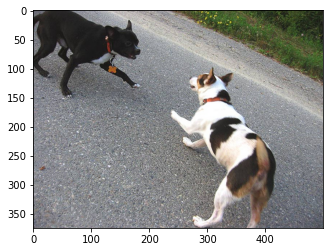

In [33]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq brown dog is sprayed with water endseq
startseq dog is being squirted with water in the face outdoors endseq
startseq dog stands on his hind feet and catches stream of water endseq
startseq jug is jumping up it is being squirted with jet of water endseq
startseq "a tan male dog is jumping up to get drink of water from spraying bottle ." endseq
--------------------Predicted--------------------
startseq dog is jumping into pool endseq


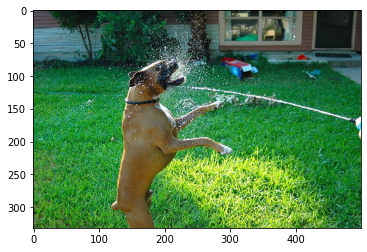

In [34]:
generate_caption("44856031_0d82c2c7d1.jpg")

---------------------Actual---------------------
startseq child in an orange sweater is playing with child in blue clothes on white couch under red painting endseq
startseq kid in yellow shirt wrestles with denim wearing kid on the white couch endseq
startseq two kids are wrestling on white sofa endseq
startseq two toddlers wrestle on white couch endseq
startseq two young boys playing on white sofa endseq
--------------------Predicted--------------------
startseq two children are wrestling in the air endseq


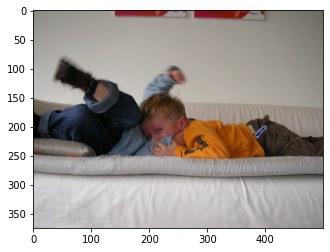

In [35]:
generate_caption('421316045_ae7a1eb4bc.jpg')

In [34]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

what you see in front of you is three people are sitting at mexican vendor


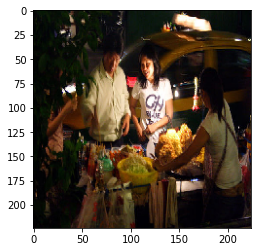

In [42]:
image_path = "E:\\relevant\\relevant\\33108590_d685bfe51c.jpg"

# load image
image = load_img(image_path, target_size=(224, 224))
plt.imshow(image)
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

generated_caption = predict_caption(model, feature, tokenizer, max_length)

# Remove startseq and endseq tokens
generated_caption = generated_caption.replace('startseq', '').replace('endseq', '').strip()

# Print or use the processed caption
print('what you see in front of you is '+ generated_caption)
import pyttsx3 as p
text_to_speech=p.init()
answer='what you see in front of you is '+ generated_caption
text_to_speech.say(answer)
text_to_speech.runAndWait()


In [54]:
#!pip install pyttsx3

In [39]:
'''
import cv2
from tqdm import tqdm
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pyttsx3 as p
import matplotlib.pyplot as plt

# Function to predict a caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # Seed the generation process
    in_text = 'startseq'
    
    # Iterate over the sequence length
    for _ in range(max_length):
        # Encode the input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        # Predict next word
        yhat = model.predict([image, sequence], verbose=0)
        
        # Get the predicted word index with the highest probability
        yhat = np.argmax(yhat)
        
        # Map the index to the word
        word = word_for_id(yhat, tokenizer)
        
        # Break if we cannot map the word
        if word is None:
            break
        
        # Add the predicted word to the input sequence
        in_text += ' ' + word
        
        # Break if we predict the end of the sequence
        if word == 'endseq':
            break
    
    return in_text

# Function to convert an integer sequence to a word sequence
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Function to process video frames
def process_video(video_path, model, vgg_model, tokenizer, max_length, frame_rate=50):
    video_capture = cv2.VideoCapture(video_path)

    # Check if the video is opened successfully
    if not video_capture.isOpened():
        print("Error: Could not open video.")
        return

    frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Processing {frame_count} frames...")

    # Loop through each frame in the video
    for frame_index in tqdm(range(frame_count)):
        # Read the frame
        ret, frame = video_capture.read()

        if not ret:
            print("Error: Could not read frame.")
            break

        # Preprocess the frame for VGG model
        frame = cv2.resize(frame, (224, 224))
        frame = img_to_array(frame)
        frame = frame.reshape((1, frame.shape[0], frame.shape[1], frame.shape[2]))
        frame = preprocess_input(frame)

        # Extract features using VGG model
        feature = vgg_model.predict(frame, verbose=0)

        # Generate caption using the trained model
        generated_caption = predict_caption(model, feature, tokenizer, max_length)

        # Remove startseq and endseq tokens
        generated_caption = generated_caption.replace('startseq', '').replace('endseq', '').strip()

        # Display or use the processed caption every 50 frames
        if frame_index % frame_rate == 0:
            print(f'What you see in front of you is: {generated_caption}')

            # Display the image
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

            # Use text-to-speech
            text_to_speech = p.init()
            text_to_speech.say(generated_caption)
            text_to_speech.runAndWait()

    # Release the video capture object
    video_capture.release()

# Example usage
video_path = "C:\\Users\\DIYA\\Downloads\\17273391-55cfc7d3d4_kbnlhwBj.mp4"
process_video(video_path, model, vgg_model, tokenizer, max_length, frame_rate=50)
'''

'\nimport cv2\nfrom tqdm import tqdm\nfrom tensorflow.keras.models import load_model\nfrom tensorflow.keras.preprocessing.image import img_to_array, load_img\nfrom tensorflow.keras.applications.vgg16 import preprocess_input\nfrom tensorflow.keras.preprocessing.sequence import pad_sequences\nimport numpy as np\nimport pyttsx3 as p\nimport matplotlib.pyplot as plt\n\n# Function to predict a caption for an image\ndef predict_caption(model, image, tokenizer, max_length):\n    # Seed the generation process\n    in_text = \'startseq\'\n    \n    # Iterate over the sequence length\n    for _ in range(max_length):\n        # Encode the input sequence\n        sequence = tokenizer.texts_to_sequences([in_text])[0]\n        sequence = pad_sequences([sequence], maxlen=max_length)\n        \n        # Predict next word\n        yhat = model.predict([image, sequence], verbose=0)\n        \n        # Get the predicted word index with the highest probability\n        yhat = np.argmax(yhat)\n        \n

In [56]:
'''
import pyttsx3 as p
text_to_speech=p.init()
answer='what you see in front of you is '+ generated_caption
text_to_speech.say(answer)
text_to_speech.runAndWait()
'''

In [43]:
import cv2
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
from tensorflow.keras.models import load_model  # If not already loaded
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pyttsx3 as p
import matplotlib.pyplot as plt

class VideoPlayer:
    def __init__(self, root, model, vgg_model, tokenizer, max_length):
        self.root = root
        self.root.title("Video Player")

        self.canvas = tk.Canvas(self.root, bg="black")  # Set canvas background color
        self.canvas.pack(fill=tk.BOTH, expand=True)

        self.img_tk = None
        self.video_path = ""
        self.frame_counter = 0  # Counter for tracking frames

        open_button = tk.Button(self.root, text="Open Video", command=self.open_file, bg="#4CAF50", fg="white")  # Green button
        open_button.pack(pady=20)

        self.frame_label = tk.Label(self.root, text="", fg="white", bg="black")  # Label for displaying frame number
        self.frame_label.pack()

        self.caption_label = tk.Label(self.root, text="", fg="white", bg="black")  # Label for displaying generated captions
        self.caption_label.pack()

        self.model = model
        self.vgg_model = vgg_model
        self.tokenizer = tokenizer
        self.max_length = max_length

    def open_file(self):
        self.video_path = filedialog.askopenfilename(filetypes=[("Video files", "*.mp4;*.avi")])
        if self.video_path:
            self.play_video()

    def play_video(self):
        cap = cv2.VideoCapture(self.video_path)

        # Set a slightly larger size for the displayed frames
        display_width = 1000
        display_height = 1000

        while True:
            ret, frame = cap.read()

            if not ret:
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Resize the frame to the specified size
            frame_resized = cv2.resize(frame_rgb, (display_width, display_height))

            img_tk = self.create_photo_image(frame_resized)

            self.canvas.create_image(0, 0, anchor=tk.NW, image=img_tk)
            self.root.update_idletasks()
            self.root.update()

            # Increment the frame counter
            self.frame_counter += 1

            # Check if 50 frames have passed
            if self.frame_counter % 50 == 0:
                frame_number = self.frame_counter // 50
                print(f"Processing frame {self.frame_counter} (Picture {frame_number})")
                self.frame_label.config(text=f"Current Frame: {frame_number}")

                # Extract features using VGG model
                feature = self.extract_features(frame_resized)

                # Generate caption using the trained model
                generated_caption = self.predict_caption(feature)

                # Remove startseq and endseq tokens
                generated_caption = generated_caption.replace('startseq', '').replace('endseq', '').strip()

                # Display the generated caption
                print(f'Generated Caption: {generated_caption}')
                self.caption_label.config(text=f"Generated Caption: {generated_caption}")

                # Add a delay to show the caption for a moment
                self.root.after(1000, lambda: self.caption_label.config(text=""))

        cap.release()

    def create_photo_image(self, image):
        img = Image.fromarray(image)
        self.img_tk = ImageTk.PhotoImage(image=img)
        return self.img_tk

    def extract_features(self, frame):
        frame = cv2.resize(frame, (224, 224))
        frame = img_to_array(frame)
        frame = frame.reshape((1, frame.shape[0], frame.shape[1], frame.shape[2]))
        frame = preprocess_input(frame)

        # Extract features using VGG model
        feature = self.vgg_model.predict(frame, verbose=0)
        return feature

    def predict_caption(self, image):
        in_text = 'startseq'
        for _ in range(self.max_length):
            # Encode the input sequence
            sequence = self.tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=self.max_length)

            # Predict next word
            yhat = self.model.predict([image, sequence], verbose=0)

            # Get the predicted word index with the highest probability
            yhat = np.argmax(yhat)

            # Map the index to the word
            word = self.word_for_id(yhat, self.tokenizer)

            # Break if we cannot map the word
            if word is None:
                break

            # Add the predicted word to the input sequence
            in_text += ' ' + word

            # Break if we predict the end of the sequence
            if word == 'endseq':
                break

        return in_text

    def word_for_id(self, integer, tokenizer):
        for word, index in tokenizer.word_index.items():
            if index == integer:
                return word
        return None


if __name__ == "__main__":
    # Load your model, vgg_model, tokenizer, and set max_length
   # model = load_model("your_model_path.h5")
    #vgg_model = None  # Placeholder for VGG model
    #tokenizer = None  # Placeholder for tokenizer
    max_length = 20  # Adjust max length accordingly

    root = tk.Tk()
    root.geometry("1000x800")  # Set a fixed window size
    app = VideoPlayer(root, model, vgg_model, tokenizer, max_length)
    root.mainloop()


Processing frame 50 (Picture 1)
Generated Caption: man in white shirt and hat is standing in front of building with neon colored flags
Processing frame 100 (Picture 2)
Generated Caption: three people are sitting at bar with drinks of their candles
Processing frame 150 (Picture 3)
Generated Caption: man in black shirt and black pants walks down the street
Processing frame 200 (Picture 4)
Generated Caption: dog is running through the grass


In [47]:
import cv2
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
from tensorflow.keras.models import load_model  # If not already loaded
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pyttsx3 as p
import matplotlib.pyplot as plt

class VideoPlayer:
    def __init__(self, root, model, vgg_model, tokenizer, max_length):
        self.root = root
        self.root.title("Video Player")

        self.canvas = tk.Canvas(self.root, bg="black")  # Set canvas background color
        self.canvas.pack(fill=tk.BOTH, expand=True)

        self.img_tk = None
        self.video_path = ""
        self.frame_counter = 0  # Counter for tracking frames

        open_button = tk.Button(self.root, text="Open Video", command=self.open_file, bg="#4CAF50", fg="white")  # Green button
        open_button.pack(pady=20)

        self.frame_label = tk.Label(self.root, text="", fg="white", bg="black")  # Label for displaying frame number
        self.frame_label.pack()

        self.caption_label = tk.Label(self.root, text="", fg="white", bg="black")  # Label for displaying generated captions
        self.caption_label.pack()

        self.model = model
        self.vgg_model = vgg_model
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Initialize text-to-speech engine
        self.text_to_speech = p.init()

    def open_file(self):
        self.video_path = filedialog.askopenfilename(filetypes=[("Video files", "*.mp4;*.avi")])
        if self.video_path:
            self.play_video()

    def play_video(self):
        cap = cv2.VideoCapture(self.video_path)

        # Set a slightly larger size for the displayed frames
        display_width = 1000
        display_height = 1000

        while True:
            ret, frame = cap.read()

            if not ret:
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Resize the frame to the specified size
            frame_resized = cv2.resize(frame_rgb, (display_width, display_height))

            img_tk = self.create_photo_image(frame_resized)

            self.canvas.create_image(0, 0, anchor=tk.NW, image=img_tk)
            self.root.update_idletasks()
            self.root.update()

            # Increment the frame counter
            self.frame_counter += 1

            # Check if 50 frames have passed
            if self.frame_counter % 50 == 0:
                frame_number = self.frame_counter // 50
                print(f"Processing frame {self.frame_counter} (Picture {frame_number})")
                self.frame_label.config(text=f"Current Frame: {frame_number}")

                # Extract features using VGG model
                feature = self.extract_features(frame_resized)

                # Generate caption using the trained model
                generated_caption = self.predict_caption(feature)

                # Remove startseq and endseq tokens
                generated_caption = generated_caption.replace('startseq', '').replace('endseq', '').strip()

                # Display the generated caption
                print(f'Generated Caption: {generated_caption}')
                self.caption_label.config(text=f"Generated Caption: {generated_caption}")

                # Speak the caption
                self.speak_caption(generated_caption)

                # Add a delay to show the caption for a moment
                self.root.after(1000, lambda: self.caption_label.config(text=""))

        cap.release()

    def create_photo_image(self, image):
        img = Image.fromarray(image)
        self.img_tk = ImageTk.PhotoImage(image=img)
        return self.img_tk

    def extract_features(self, frame):
        frame = cv2.resize(frame, (224, 224))
        frame = img_to_array(frame)
        frame = frame.reshape((1, frame.shape[0], frame.shape[1], frame.shape[2]))
        frame = preprocess_input(frame)

        # Extract features using VGG model
        feature = self.vgg_model.predict(frame, verbose=0)
        return feature

    def predict_caption(self, image):
        in_text = 'startseq'
        for _ in range(self.max_length):
            # Encode the input sequence
            sequence = self.tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=self.max_length)

            # Predict next word
            yhat = self.model.predict([image, sequence], verbose=0)

            # Get the predicted word index with the highest probability
            yhat = np.argmax(yhat)

            # Map the index to the word
            word = self.word_for_id(yhat, self.tokenizer)

            # Break if we cannot map the word
            if word is None:
                break

            # Add the predicted word to the input sequence
            in_text += ' ' + word

            # Break if we predict the end of the sequence
            if word == 'endseq':
                break

        return in_text

    def word_for_id(self, integer, tokenizer):
        for word, index in tokenizer.word_index.items():
            if index == integer:
                return word
        return None

    def speak_caption(self, caption):
        # Speak the caption using text-to-speech
        full_caption = f"What you see in front of you is {caption}"
        self.text_to_speech.say(full_caption)
        self.text_to_speech.runAndWait()


if __name__ == "__main__":
    # Load your model, vgg_model, tokenizer, and set max_length
    max_length = 20  # Adjust max length accordingly

    root = tk.Tk()
    root.geometry("1000x800")  # Set a fixed window size
    app = VideoPlayer(root, model, vgg_model, tokenizer, max_length)
    root.mainloop()


Processing frame 50 (Picture 1)
Generated Caption: two people are fishing in lake
Processing frame 100 (Picture 2)
Generated Caption: dog is jumping over green pool
Processing frame 150 (Picture 3)
Generated Caption: two men in sports uniforms are playing game
Processing frame 200 (Picture 4)
Generated Caption: man in green jacket and red helmet is riding bike
